In [3]:
import os
import pickle
from collections import Counter

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

from sklearn.decomposition import PCA
from scipy.stats import f
import scipy.stats as stats

In [4]:
base_path = '/sciclone/proj-ds/geograd/stmorse/reddit/km/km70'

In [5]:
Ck = 70
years = range(2006, 2022+1)
months = [f'{mo:02}' for mo in range(1,12+1)]
yrmo = [(yr, mo) for yr in years for mo in months]

with open(os.path.join(base_path, f'align/cu2d.npz'), 'rb') as f:
    Cu2d = np.load(f)['Cu2d']
print('cu2d: ', Cu2d.shape)

with open(os.path.join(base_path, f'align/align_model_HDBSCAN.pkl'), 'rb') as f:
    hdbs = pickle.load(f)
print('num labels: ', np.amax(hdbs.labels_))

C = [] 
for year, month in yrmo:
    with open(os.path.join(base_path, f'models/model_cc_{year}-{month}.npz'), 'rb') as f:
        cc = np.load(f)['cc']
        if Ck != cc.shape[0]: print(Ck, cc.shape[0])
        C.append(cc)
C = np.vstack(C)

T = []
for year, month in [(yr, mo) for yr in years for mo in months]:
    with open(os.path.join(base_path, f'tfidf/tfidf_{year}-{month}.pkl'), 'rb') as f:
        tfidf = pickle.load(f)
        # TODO: hacky, maybe 'tfidf' shouldn't be a dict
        for k in range(len(tfidf['tfidf'].keys())):
            T.append(tfidf['tfidf'][k]['keywords'])

cu2d:  (14280, 2)
num labels:  1417


In [6]:
a, b = np.unique(hdbs.labels_, return_counts=True)
print(b[0])
print(np.amax(b[1:]))

3297
98


In [7]:
cois = np.arange(np.amax(hdbs.labels_))

group_keywords = {}

for coi in cois:
    idx = np.where(hdbs.labels_ == coi)[0]
    
    if len(idx) < 3: 
        continue

    all_words = []
    for x in idx:
        all_words.extend(T[x][:10])
    
    # Count the frequency of each word
    word_counts = Counter(all_words)

    # Find the most common word
    common = word_counts.most_common(3)
    s_common = ' '.join([f'"{word}" ({count})' for word, count in common])

    group_keywords[coi] = common[0][0]

    print(f'{coi}: {s_common}')

0: "ron" (10) "republican" (10) "supporters" (10)
1: "mccain" (11) "obama" (11) "president" (7)
2: "über" (2) "excluded" (2) "eve" (2)
3: "megusta" (14) "sadtroll" (13) "rtroll" (13)
4: "ಠ_ಠ" (3) "excited" (2) "excessive" (2)
5: "twismug" (9) "b24" (6) "ohcrap" (6)
6: "uh" (6) "ohcomeon" (4) "twismug" (4)
7: "raritywhy" (4) "uh" (4) "ohcomeon" (4)
8: "00" (4) "și" (2) "özil" (2)
9: "humor" (24) "laugh" (24) "joke" (23)
10: "ಠ_ಠ" (6) "ex" (2) "evaluate" (2)
11: "ಠ_ಠ" (2) "üm" (1) "existential" (1)
12: "downmodded" (7) "downmod" (7) "downmodding" (7)
13: "downmodded" (5) "downmod" (5) "upmod" (5)
14: "insurance" (12) "health" (12) "healthcare" (12)
15: "insurance" (6) "health" (6) "healthcare" (6)
16: "kids" (5) "age" (5) "kid" (4)
17: "karma" (3) "upvote" (3) "downvote" (3)
18: "karma" (5) "upvote" (5) "upvotes" (5)
19: "downvoted" (21) "upvoted" (21) "upvote" (21)
20: "無茶しやがって" (2) "什么" (2) "の方が正しいと思う" (1)
21: "joke" (4) "humor" (4) "funnier" (4)
22: "translate" (6) "english" (5) "tran

# topic BoW changes

In [18]:
18 % 12

6

In [31]:
coi = 842

# indices of this topic group in the total k*T set
idx = np.where(hdbs.labels_ == coi)[0]

print(f'Group keywords {coi}: {group_keywords[coi]}')

for i in idx:
    p = i // 50
    y = 2006 + (p // 12)
    m = (p % 12) + 1
    print(f'Period {i // 50} ({y}-{m}) cluster {i % 50}: {T[i]}')

Group keywords 842: science
Period 2 (2006-3) cluster 27: ['women' 'iq' 'men' 'scientific' 'evolution' 'intelligent' 'fortune'
 'biology' 'theories' 'woman' 'economics' 'guilty' 'scientists' 'married'
 'gender' 'professors' 'energy' 'male' 'colleges' 'biased']
Period 3 (2006-4) cluster 38: ['universe' 'radiation' 'evolution' 'animals' 'radioactive' 'humanism'
 'aging' 'animal' 'gene' 'species' 'meaning' 'lifespan' 'natural'
 'contaminated' 'gaining' 'cockroaches' 'qed' 'simulation' 'beetles'
 'implode']
Period 7 (2006-8) cluster 3: ['evolution' 'women' 'differences' 'science' 'selection' 'sex'
 'psychology' 'theory' 'arbitrary' 'scientists' 'birth' 'statistically'
 'rules' 'nature' 'survival' 'study' 'studies' 'species' 'brains'
 'improbable']
Period 16 (2007-5) cluster 41: ['science' 'singularity' 'universe' 'experiment' 'theoretical'
 'simulation' 'possibility' 'edu' 'impossible' 'scientific' 'machines'
 'beginning' 'computers' 'nonintuitive' 'entertain' 'ice' 'intelligently'
 'sicp'

# umap plots

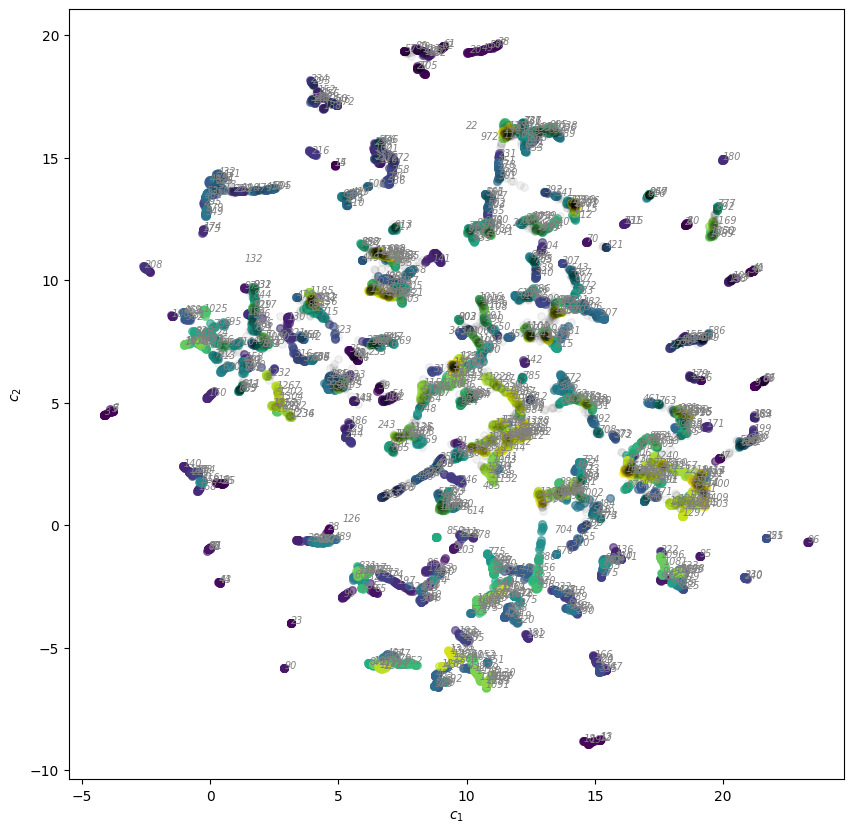

In [8]:
fig, ax = plt.subplots(1,1, figsize=(10,10))

n_clusters = np.amax(hdbs.labels_)
colors = plt.cm.viridis(np.linspace(0, 1, n_clusters))

for k in range(2, n_clusters):
    # NOTE: ignore coi=1 for viz (outlier)
    # if k == 1: continue

    idx = np.where(hdbs.labels_ == k)[0]

    if len(idx) < 5:
        continue

    # if np.any(Cu2d[idx,0] < 0) or np.any(Cu2d[idx,1] < 0):
    #     continue
    
    ax.scatter(Cu2d[idx,0], Cu2d[idx,1], s=30, color=colors[k], alpha=0.6, label=k)

    centroid = np.average(Cu2d[idx,:], axis=0)
    ax.text(centroid[0], centroid[1], k, color='gray', fontsize='x-small', fontstyle='italic')

# plot uncategorized
idx = np.where(hdbs.labels_ == -1)[0]
uncat = Cu2d[idx,:]
uncat = uncat[(uncat[:,0] > 0) & (uncat[:,1] > 0)]
ax.scatter(uncat[:,0], uncat[:,1], s=30, c='k', alpha=0.05)

ax.set_xlabel('$c_1$')
ax.set_ylabel('$c_2$')

# ax.set_xlim([0,25])
# ax.set_ylim([0,25])

plt.show()

/local/scr/stmorse/TMPDIR/ipykernel_3590853/3867923104.py:29: UserWarning: *c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
  ax.scatter(Cu2d[idx,0], Cu2d[idx,1], s=30, c=colors[coi], alpha=0.6, label=k)


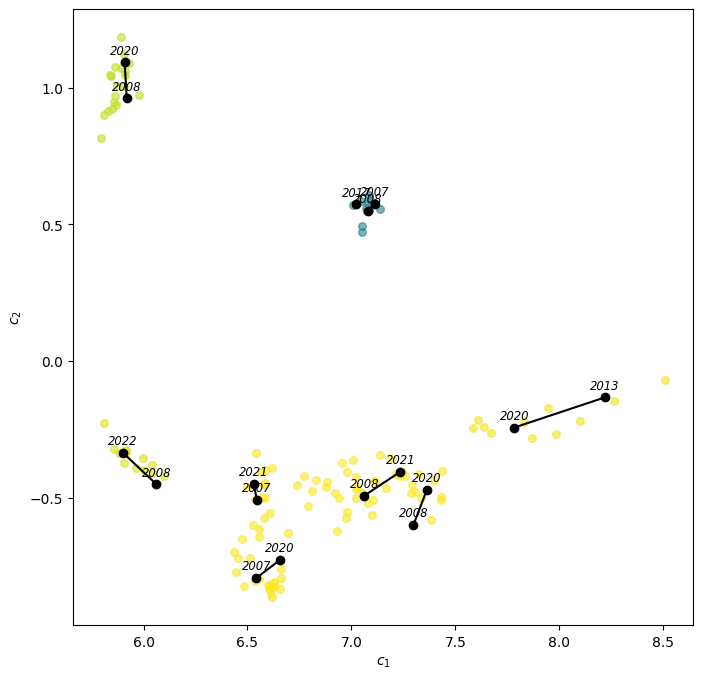

In [59]:
cois = [949, 999, 905, 906, 998, 1001, 1004, 983, 445, 448]
# hlabels = [f'{c}' for c in cois]
hlabels = ['political', 'voting', 'racism', ' ', 'republicans', 'president', 'campaign', 'ron paul', '', 'news']
rgs = {
    949: [2, 16],
    999: [1, 13,14,15] ,
    905: [2, 13,14,15,16],
    906: [],
    998: [1, 15],
    1001: [2, 15],
    1004: [2, 14],
    983: [7, 14],
    445: [1,2],
    # 448: [6,7,8, 11]
    448: [11]   
}

fig, ax = plt.subplots(1,1, figsize=(8,8))

# use the same colors as full plot
n_clusters = np.amax(hdbs.labels_)
colors = plt.cm.viridis(np.linspace(0, 1, n_clusters))

N = len(years)

for i, coi in enumerate(cois):
    idx = np.where(hdbs.labels_ == coi)[0]

    ax.scatter(Cu2d[idx,0], Cu2d[idx,1], s=30, c=colors[coi], alpha=0.6, label=k)
    # ax.plot(Cu2d[idx,0], Cu2d[idx,1], color=colors[coi], linestyle='-', marker='o')

    # if coi in [832, 891, 774, 1051, 1056]:
    if coi in cois:
        annual_avgs = []
        # for y in [1, N // 2, N-1]:
        # for y in range(N):
        # for y in [idx[0] // 50, (idx[-1] // 50)-1]:
        if len(rgs[coi]) == 0:
            continue
        for y in rgs[coi]:
            # indices split marks
            # NOTE: assumes Ck=50 and 12 non-overlapping month-windows
            split_0, split_1 = 12 * 50 * y, 12 * 50 * (y+1)

            # get just indices in this year
            sub = idx[np.where((idx >= split_0) & (idx < split_1))[0]]

            # if empty, skip
            if len(sub) == 0:
                continue

            # get average position in this year
            avg = np.mean(Cu2d[sub,:], axis=0)
            ax.text(avg[0] - 0.07, avg[1] + 0.03, years[y], fontstyle='italic', fontsize='small')
            annual_avgs.append(avg)
        annual_avgs = np.vstack(annual_avgs)

        ax.plot(annual_avgs[:,0], annual_avgs[:,1], 'ko-')
        
    # centroid = np.average(Cu2d[idx,:], axis=0)
    # ax.text(centroid[0] + 0.15, centroid[1] + 0.05, hlabels[i])

ax.set_xlabel('$c_1$')
ax.set_ylabel('$c_2$')

# ax.set_ylim([8,12])
# ax.set_xlim([11,15])

plt.show()

In [148]:
np.where((Cu2d[:,0] > 7.45) & (Cu2d[:,0] < 7.75) & (Cu2d[:,1] < 0) & (Cu2d[:,1] > -0.5))[0]

array([ 835, 1165, 1368, 1468, 1636, 1646, 1700, 2022, 2592, 2631, 2855,
       2989, 3106, 4168, 7608, 7984, 8477])

In [149]:
hdbs.labels_[np.where((Cu2d[:,0] > 7.45) & (Cu2d[:,0] < 7.75) & (Cu2d[:,1] < 0) & (Cu2d[:,1] > -0.5))[0]]

array([1005,   -1, 1005, 1005,   -1, 1005, 1005,   -1, 1005,   -1,  983,
        983,  983, 1005, 1005,  983, 1005])

In [152]:
T[1468]

array(['mccain', 'obama', 'election', 'candidate', 'speech', 'charisma',
       'win', 'president', 'politician', 'presidential', 'republicans',
       'campaign', 'november', 'lose', 'flip', 'john', 'seat', 'vote',
       'debates', 'himself'], dtype=object)

# tables

In [9]:
res = []

for coi in np.unique(hdbs.labels_):
    idx = np.where(hdbs.labels_ == coi)[0]
    
    if len(idx) < 4:
        continue

    # Compute the step sizes (normed distances) between consecutive points
    x = C[idx, :]
    steps = x[1:,:] - x[:-1,:]
    stepsizes = np.linalg.norm(steps, axis=1)
    
    # Record the absolute total and average of these step sizes
    total_step_size = np.sum(stepsizes)
    average_step_size = np.mean(stepsizes)
    
    res.append([coi, len(idx), total_step_size, average_step_size])

res = pd.DataFrame(res, columns=['coi', 'size', 'total', 'average'])
res = res[res['coi'] != -1]
res.head()

,coi,size,total,average
1,0,5,0.690289,0.172572
2,1,7,0.390633,0.065106
3,3,4,0.089571,0.029857
4,4,19,2.801309,0.155628
5,5,7,0.402645,0.067107


In [10]:
res.sort_values(by='total', ascending=False).head(10)

,coi,size,total,average
620,812,79,15.879584,0.203584
541,712,58,12.734079,0.223405
752,987,51,12.127476,0.242550
40,53,54,10.834688,0.204428
45,60,50,9.487119,0.193615
405,540,38,8.618882,0.232943
325,428,45,8.135351,0.184894
118,149,83,8.058168,0.098270
196,258,41,7.625491,0.190637
72,93,37,6.677652,0.185490


In [11]:
res.sort_values(by='total', ascending=True).head(10)

,coi,size,total,average
13,13,4,0.052528,0.017509
17,20,4,0.071867,0.023956
171,222,4,0.086596,0.028865
305,405,4,0.089483,0.029828
3,3,4,0.089571,0.029857
186,244,5,0.112841,0.028210
32,40,5,0.116557,0.029139
14,14,9,0.120647,0.015081
26,32,6,0.131356,0.026271
181,239,4,0.133720,0.044573


In [18]:
# compute total displacement

res2 = []

for coi in np.unique(hdbs.labels_):
    if coi == -1:
        continue

    idx = np.where(hdbs.labels_ == coi)[0]
    
    if len(idx) < 5:
        continue

    # compute the distance between start and end point
    displacement = np.linalg.norm(C[idx[0],:] - C[idx[-1],:])

    # compute diameter
    diameter = np.max([np.linalg.norm(C[i] - C[j]) for i in idx for j in idx])
    
    res2.append([coi, len(idx), displacement, diameter])

res2 = pd.DataFrame(res2, columns=['coi', 'size', 'displacement', 'diameter'])
res2.head()

,coi,size,displacement,diameter
0,0,5,0.265926,0.399949
1,1,7,0.147401,0.181729
2,4,19,0.223856,0.400920
3,5,7,0.101567,0.117214
4,6,9,0.038287,0.096811


In [20]:
res2.sort_values(by='displacement', ascending=False).head(20)

,coi,size,displacement,diameter
33,53,54,0.393727,0.451854
166,290,7,0.387547,0.387547
443,771,10,0.374773,0.465199
313,561,7,0.363844,0.366331
242,428,45,0.359207,0.383505
405,712,58,0.355897,0.401255
458,798,17,0.354746,0.457124
550,949,14,0.353290,0.456051
583,999,22,0.351543,0.393977
384,676,8,0.351281,0.386536


# diff plots

In [6]:
coi = 906

labs, cnts = np.unique(hdbs.labels_, return_counts=True)
labels_trim = np.array([i for i, c in zip(labs, cnts) if i != -1 and c >= 10])
n = len(labels_trim)
N = len(years)

mx = np.nan * np.ones((N, n))
for y in range(N):
    split_0, split_1 = 12 * 50 * y, 12 * 50 * (y+1)

    idx_a = np.where(hdbs.labels_==coi)[0]
    sub_a = idx_a[np.where((idx_a >= split_0) & (idx_a < split_1))[0]]

    if len(sub_a) == 0:
        continue
   
    avg_a = np.mean(C[sub_a,:], axis=0)

    for xc in range(n):
        coi_c = labels_trim[xc]
        idx_c = np.where(hdbs.labels_==coi_c)[0]
        sub_c = idx_c[np.where((idx_c >= split_0) & (idx_c < split_1))[0]]

        if len(sub_c) == 0:
            continue

        avg_c = np.mean(C[sub_c,:], axis=0)
        diff  = np.linalg.norm(avg_a - avg_c)

        mx[y,xc] = diff

change = mx[1:,:] - mx[:-1,:]

# find topic groups "nearby" to coi
thresh = 0.4
idx = np.where(hdbs.labels_ == coi)[0]
centroid_a = np.mean(C[idx,:], axis=0)
nearby_cois = []
for c2 in labels_trim:
    idx = np.where(hdbs.labels_ == c2)[0]
    centroid_c = np.mean(C[idx,:], axis=0)
    if np.linalg.norm(centroid_a - centroid_c) <= thresh:
        nearby_cois.append(c2)
nearby_cois = np.array(nearby_cois)
print(len(nearby_cois))

53


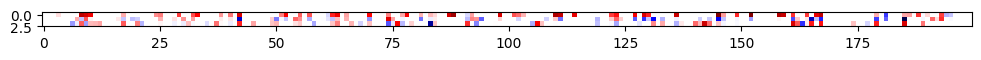

In [7]:
fig, ax = plt.subplots(1,1, figsize=(12,6))
ax.imshow(change[4:7,:], cmap='seismic', interpolation='none')

In [7]:
# Find columns with no NaN values
valid_columns = np.all(~np.isnan(change[4:7,:]), axis=0)
columns_with_no_nans = np.where(valid_columns)[0].astype(int)

# Find columns of change[10:12,:] with only one NaN
valid_columns_2 = np.where(np.sum(np.isnan(change[4:7,:]), axis=0) <= 1)[0]

In [8]:
nearby_indices = np.where(np.isin(labels_trim, nearby_cois))[0]
nearby_no_nans = np.intersect1d(nearby_indices, valid_columns_2)
print(nearby_no_nans)

[ 42  52  61  81  83  84  91 102 111 123 141 145 146 152 162 179 181 185
 189 193 195]


[Text(0, 0, '2010'), Text(0, 1, '2011'), Text(0, 2, '2012')]

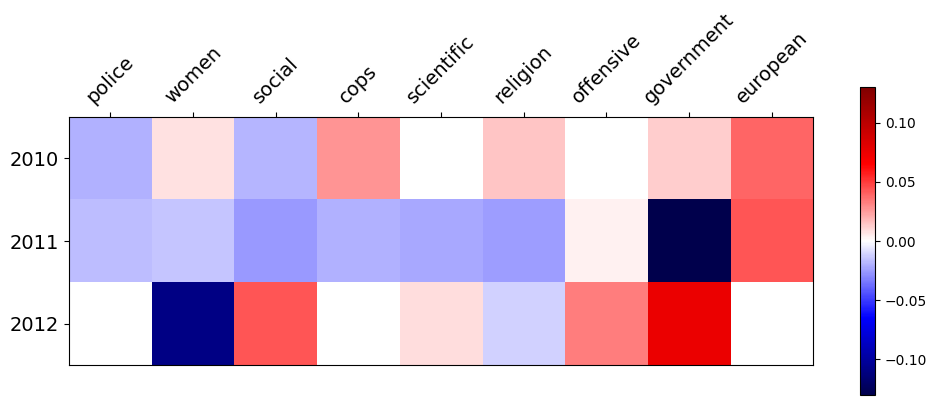

In [11]:
tidx = np.array([61, 83, 91, 102, 141, 146, 162, 185, 193,])

fig, ax = plt.subplots(1,1, figsize=(12,4))
cb = ax.imshow(change[4:7,tidx], cmap='seismic', interpolation='none', vmin=-0.13, vmax=0.13)

fig.colorbar(cb)
ax.set_xticks(range(len(tidx)))
ax.set_xticklabels([group_keywords[coi] for coi in labels_trim[tidx]], 
                   rotation=45, fontsize=14)
ax.xaxis.set_ticks_position('top')
ax.set_yticks([0,1, 2])
ax.set_yticklabels([2010, 2011, 2012], fontsize=14)

In [48]:
coi = 158

labs, cnts = np.unique(hdbs.labels_, return_counts=True)
labels_trim = np.array([i for i, c in zip(labs, cnts) if i != -1 and c >= 10])
n = len(labels_trim)
N = len(years)

mx = np.nan * np.ones((N, n))
for y in range(N):
    split_0, split_1 = 12 * 50 * y, 12 * 50 * (y+1)

    idx_a = np.where(hdbs.labels_==coi)[0]
    sub_a = idx_a[np.where((idx_a >= split_0) & (idx_a < split_1))[0]]

    if len(sub_a) == 0:
        continue
   
    avg_a = np.mean(C[sub_a,:], axis=0)

    for xc in range(n):
        coi_c = labels_trim[xc]
        idx_c = np.where(hdbs.labels_==coi_c)[0]
        sub_c = idx_c[np.where((idx_c >= split_0) & (idx_c < split_1))[0]]

        if len(sub_c) == 0:
            continue

        avg_c = np.mean(C[sub_c,:], axis=0)
        diff  = np.linalg.norm(avg_a - avg_c)

        mx[y,xc] = diff

change = mx[1:,:] - mx[:-1,:]

# find topic groups "nearby" to coi
thresh = 0.45
idx = np.where(hdbs.labels_ == coi)[0]
centroid_a = np.mean(C[idx,:], axis=0)
nearby_cois = []
for c2 in labels_trim:
    idx = np.where(hdbs.labels_ == c2)[0]
    centroid_c = np.mean(C[idx,:], axis=0)
    if np.linalg.norm(centroid_a - centroid_c) <= thresh:
        nearby_cois.append(c2)
nearby_cois = np.array(nearby_cois)
print(len(nearby_cois))

135


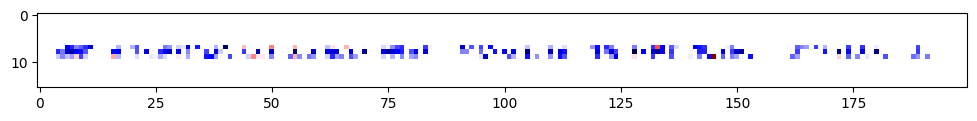

In [27]:
fig, ax = plt.subplots(1,1, figsize=(12,6))
ax.imshow(change[:,:], cmap='seismic', interpolation='none')

In [49]:
a, b = 7, 10

# Find columns with no NaN values
valid_columns = np.all(~np.isnan(change[a:b,:]), axis=0)
columns_with_no_nans = np.where(valid_columns)[0].astype(int)

# Find columns of change with only one NaN
valid_columns_2 = np.where(np.sum(np.isnan(change[a:b,:]), axis=0) <= 1)[0]

In [50]:
nearby_indices = np.where(np.isin(labels_trim, nearby_cois))[0]
nearby_no_nans = np.intersect1d(nearby_indices, valid_columns_2)
print(nearby_no_nans)

[  5   6   7   8   9  10  17  28  32  36  38  39  44  50  55  64  70  74
  75  77  91  95 105 110 112 113 120 122 123 128 132 133 136 142 143 147
 149 150 151 169 172 174 177 180]


In [53]:
[(int(t), int(l)) for t, l in zip(nearby_no_nans, labels_trim[nearby_no_nans])]

[(5, 29),
 (6, 44),
 (7, 50),
 (8, 53),
 (9, 56),
 (10, 60),
 (17, 93),
 (28, 137),
 (32, 169),
 (36, 206),
 (38, 221),
 (39, 237),
 (44, 271),
 (50, 292),
 (55, 326),
 (64, 381),
 (70, 412),
 (74, 428),
 (75, 435),
 (77, 466),
 (91, 540),
 (95, 566),
 (105, 630),
 (110, 646),
 (112, 655),
 (113, 659),
 (120, 691),
 (122, 695),
 (123, 712),
 (128, 738),
 (132, 758),
 (133, 767),
 (136, 774),
 (142, 800),
 (143, 808),
 (147, 817),
 (149, 826),
 (150, 839),
 (151, 841),
 (169, 901),
 (172, 913),
 (174, 919),
 (177, 935),
 (180, 956)]

[Text(0, 0, '2013'), Text(0, 1, '2014'), Text(0, 2, '2015')]

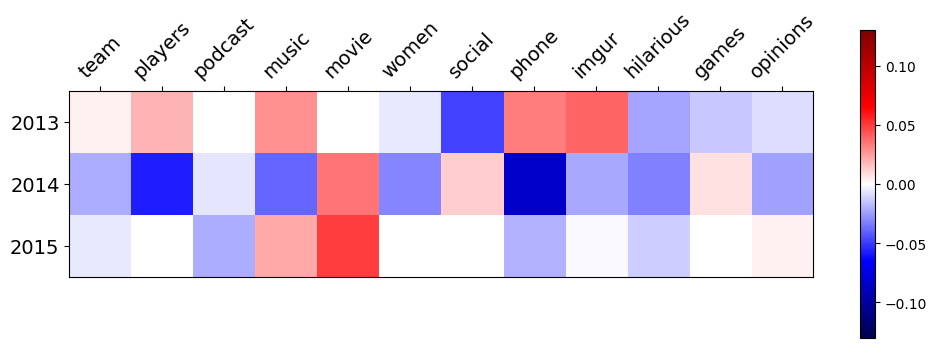

In [62]:
# tidx = np.array([8, 32, 39, 44, 105, 112, 120, 123, 128, 132, 133, 136, 147, 150,])
tidx = np.array([9, 28, 36, 38, 39, 77, 91, 105, 113, 120, 122, 174])
# tidx = nearby_no_nans

fig, ax = plt.subplots(1,1, figsize=(12,4))
cb = ax.imshow(change[a:b,tidx], cmap='seismic', interpolation='none', vmin=-0.13, vmax=0.13)

fig.colorbar(cb)

hlabels = [group_keywords[coi] for coi in labels_trim[tidx]]
hlabels[2] = 'podcast'
ax.set_xticks(range(len(tidx)))
ax.set_xticklabels(hlabels, 
                   rotation=45, fontsize=14)
ax.xaxis.set_ticks_position('top')
ax.set_yticks([0,1, 2])
ax.set_yticklabels([years[i] for i in range(a,b)], fontsize=14)

# full diffs

In [6]:
labs, cnts = np.unique(hdbs.labels_, return_counts=True)
labels_trim = [i for i, c in zip(labs, cnts) if i != -1 and c >= 20]
n = len(labels_trim)
N = len(years)

# diffs holds the dist in year_i between group_j and group_k
# NOTE: upper triangular bc dist is symmetric
# (year, label, label)
diffs = np.nan * np.ones((N, n, n))
for y in range(N):
    # indices split marks
    # NOTE: assumes Ck=50 and 12 non-overlapping month-windows
    split_0, split_1 = 12 * 50 * y, 12 * 50 * (y+1)

    # loop cluster of row
    for xa in range(n):
        # get label number
        coi_a = labels_trim[xa]

        # all indices within C
        idx_a = np.where(hdbs.labels_==coi_a)[0]

        # get just indices in this year
        sub_a = idx_a[np.where((idx_a >= split_0) & (idx_a < split_1))[0]]

        # loop cluster of column
        for xb in range(xa, n):
            coi_b = labels_trim[xb]
            idx_b = np.where(hdbs.labels_==coi_b)[0]
            sub_b = idx_b[np.where((idx_b >= split_0) & (idx_b < split_1))[0]]

            # if either cluster is empty this year, skip
            if len(sub_a) == 0 or len(sub_b) == 0:
                diffs[y,xa,xb] = np.nan
                continue

            # compute average centroid
            avg_a = np.mean(C[sub_a], axis=0)
            avg_b = np.mean(C[sub_b], axis=0)

            # compute difference
            diff = np.linalg.norm(avg_a - avg_b)
            diffs[y,xa,xb] = diff

# compute change in distance from year_i to year_i+1
change = diffs[1:,:,:] - diffs[:-1,:,:]
print(change.shape)

(16, 37, 37)


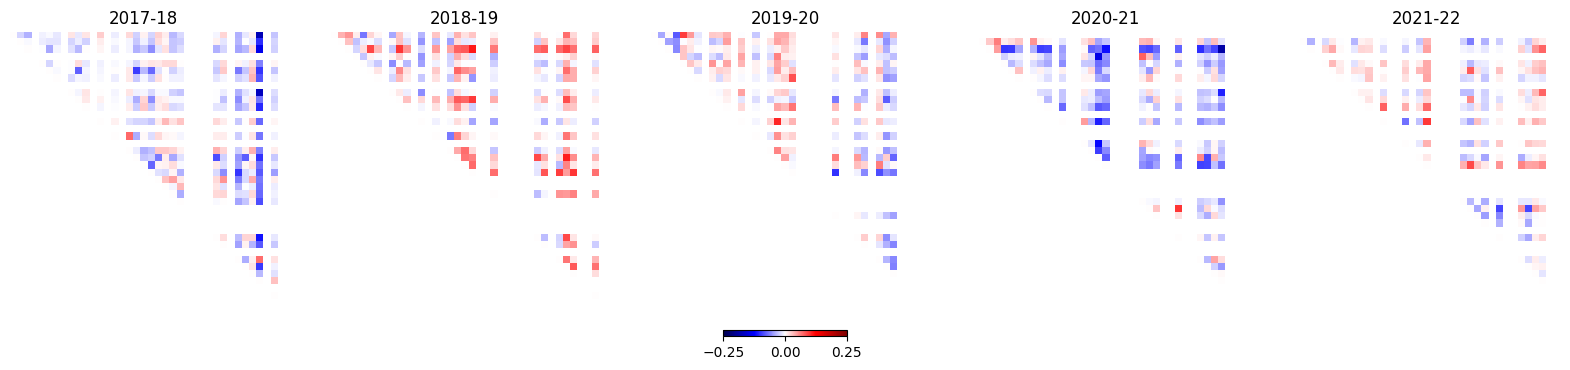

In [7]:
fig, axs = plt.subplots(1,5, figsize=(20, 4))

titles = [f'{years[y]}-{str(years[y+1])[-2:]}' for y in range(11, 16)]
for j, (ix, ax) in enumerate(zip(range(11, 16), axs.ravel())):
    cb = ax.imshow(change[ix,:,:], 
                 cmap='seismic', interpolation='none',
                 vmin=-0.25, vmax=0.25)
    
    ax.axis('off')
    ax.set_title(titles[j])

fig.colorbar(cb, ax=axs, orientation='horizontal', fraction=0.02, pad=0.1)
# plt.tight_layout()
plt.show()

In [8]:
for k, label in enumerate(labels_trim):
    print(k, label, len(np.where(hdbs.labels_ == label)[0]), group_keywords[label])

0 44 29 dragon
1 53 54 number
2 60 50 gun
3 78 20 pm
4 87 28 team
5 93 37 animals
6 129 20 area
7 130 20 city
8 149 83 damage
9 258 41 parents
10 271 26 hour
11 304 24 smoke
12 324 23 luck
13 326 35 cars
14 358 44 delicious
15 374 28 00
16 412 20 water
17 428 45 wear
18 449 34 therapy
19 540 38 social
20 586 25 ha
21 630 24 phone
22 712 58 spelling
23 767 23 update
24 774 27 laugh
25 800 20 ur
26 811 30 religion
27 812 79 religion
28 826 27 bang
29 842 22 science
30 889 26 00
31 919 41 opinions
32 929 34 00
33 972 22 government
34 987 51 iraq
35 999 22 republican
36 1001 33 president


[Text(0, 0, ''), Text(0, 1, ''), Text(0, 2, ''), Text(0, 3, '')]

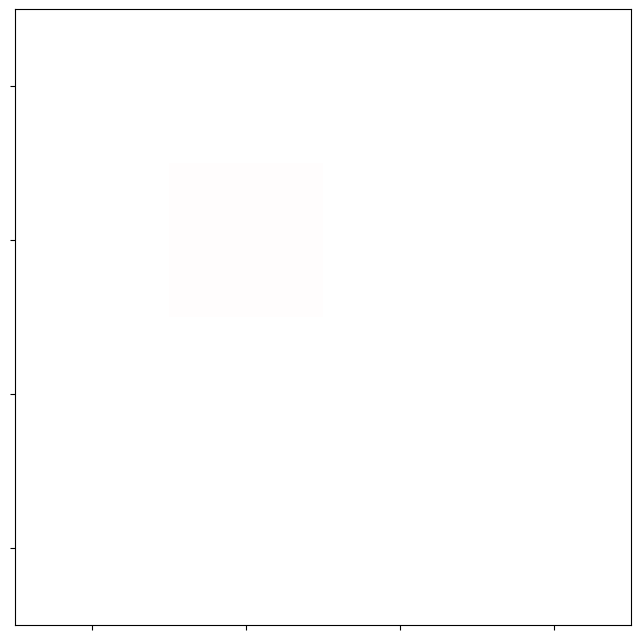

In [12]:
fig, ax = plt.subplots(1,1, figsize=(8,8))

idx = np.array([33, 34, 35, 36])
hlabels = ['' for _ in range(len(idx))]

ax.imshow(change[10,idx,:][:,idx], cmap='seismic', vmin=-0.25, vmax=0.25)

ax.set_xticks(np.arange(len(hlabels)))
ax.set_yticks(np.arange(len(hlabels)))
ax.set_xticklabels(hlabels, rotation=90)
ax.set_yticklabels(hlabels)

In [92]:
labs, cnts = np.unique(hdbs.labels_, return_counts=True)
# labels_trim = [i for i, c in zip(labs, cnts) if i != -1 and c >= 100]
labels_trim = [9, 10]
n = len(labels_trim)
P = len(years) * 12

# will hold the counts of cluster n in period p
M = np.zeros((P, n))
for j, coi in enumerate(labels_trim):
    for p in range(P):
        split_0, split_1 = p * 50, (p+1) * 50
        idx = np.where(hdbs.labels_ == coi)[0]
        sub = idx[np.where((idx >= split_0) & (idx < split_1))[0]]
        M[p,j] = len(sub)

M.shape

(204, 2)

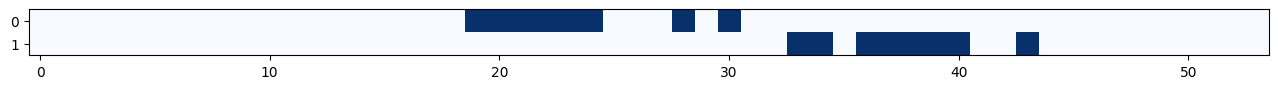

In [93]:
fig, ax = plt.subplots(1,1, figsize=(16,4))
ax.imshow(M[150:].T, cmap='Blues')

# significance testing

In [20]:
def generate_rank1_steps(n_steps=1000, dim=384, sigma=1.0, noise=1e-3):
    # 1) Random direction (normalize a random vector)
    v = np.random.randn(dim)
    v /= np.linalg.norm(v)
    
    # 2) Generate steps mostly along v
    #    scalar drawn from N(0, sigma^2) plus small isotropic noise
    steps = []
    for _ in range(n_steps):
        s = np.random.normal(0, sigma)
        eps = noise * np.random.randn(dim)
        delta = s * v + eps
        steps.append(delta)
    
    return np.array(steps)

In [21]:
def variance_concentration_ratio(steps):
    # compute the empirical cov
    cov_mx = np.cov(steps, rowvar=False)

    # eigen decomp
    evs, _ = np.linalg.eigh(cov_mx)

    # sort and grab largest and sum
    evs = np.sort(evs)[::-1]
    ev_max = evs[0]
    ev_sum = np.sum(evs)

    # handle case when steps all zero
    if ev_sum <= 0:
        return 0
    
    r = ev_max / ev_sum
    return r, ev_max, ev_sum, evs

In [17]:
def spectral_entropy(eigenvalues):
    """
    Compute the spectral Shannon entropy of a set of eigenvalues.

    Parameters
    ----------
    eigenvalues : np.ndarray
        1D array of eigenvalues (can be unnormalized).

    Returns
    -------
    float
        Shannon entropy of the normalized eigenvalues, i.e.
        H = -sum(p_i * log(p_i)), where p_i = lambda_i / sum(lambda_i).
    """
    total = np.sum(eigenvalues)
    if total <= 0:
        # Edge case: no valid total variance
        return 0.0

    p = eigenvalues / total

    # Filter out zero or negative values to avoid log(0).
    p_nonzero = p[p > 0]
    H = -np.sum(p_nonzero * np.log(p_nonzero))
    return H

def effective_rank(eigenvalues):
    """
    Compute the effective rank = exp(H), where H is the spectral Shannon entropy.

    Parameters
    ----------
    eigenvalues : np.ndarray
        1D array of eigenvalues.

    Returns
    -------
    float
        Effective rank, a single scalar in [1, d] if eigenvalues >= 0.
    """
    H = spectral_entropy(eigenvalues)
    return np.exp(H)

def hotelling_t2_test_single(X, mu0=None):
    """
    Conduct a one-sample Hotelling T^2 test for the hypothesis H0: E[X] = mu0.
    
    Parameters
    ----------
    X : (n, d) array-like
        The sample data. Each row is an observation in R^d.
    mu0 : (d,) array-like or None
        The hypothesized mean vector. If None, tests against a zero vector.
        
    Returns
    -------
    T2_stat : float
        The Hotelling T^2 statistic.
    F_stat : float
        The equivalent F-statistic.
    p_value : float
        The p-value from the F-distribution.
    """
    X = np.asarray(X, dtype=float)
    n, d = X.shape
    
    if mu0 is None:
        mu0 = np.zeros(d)
    else:
        mu0 = np.asarray(mu0, dtype=float)
        if mu0.shape != (d,):
            raise ValueError("mu0 must be of shape (d,).")
    
    # Sample mean
    X_bar = X.mean(axis=0)

    # Sample covariance (unbiased) and inverse
    S = np.cov(X, rowvar=False)  # shape (d, d)
    # Might need a pseudo-inverse if S is singular in high dimensions
    S_inv = np.linalg.inv(S)
    
    # Hotelling T^2
    diff = X_bar - mu0
    T2_stat = n * diff @ S_inv @ diff
    
    # Convert to F-statistic
    # F ~ F(d, n-d) under H0
    F_stat = ((n - d) / (d * (n - 1))) * T2_stat
    
    # p-value
    p_value = 1 - f.cdf(F_stat, d, n - d)
    
    return T2_stat, F_stat, p_value

def shrinkage_covariance(X, lam=0.1):
    """
    Compute a simple shrinked covariance matrix:
        Sigma_reg = (1 - lam) * S + lam * mu * I
    where S is the sample covariance, mu is the average diagonal of S.

    Parameters
    ----------
    X : array-like of shape (n, d)
        Data matrix, rows are observations.
    lam : float, optional
        Shrinkage parameter in [0, 1]. Default=0.1

    Returns
    -------
    Sigma_reg : (d, d) ndarray
        Regularized covariance matrix.
    """
    X = np.asarray(X)
    n, d = X.shape

    # Center columns
    X_centered = X - X.mean(axis=0)

    # Sample covariance
    S = np.cov(X_centered, rowvar=False, ddof=1)

    # Average variance along diagonal
    mu = np.trace(S) / d

    # Shrinked covariance
    Sigma_reg = (1 - lam) * S + lam * mu * np.eye(d)
    return Sigma_reg

def one_sample_t2_shrinkage(steps, lam=0.1):
    """
    Perform a one-sample T^2 test with a shrinked covariance matrix
    to test H0: mean(steps) = 0 in d-dim.

    Parameters
    ----------
    steps : array-like of shape (n, d)
        Observations (e.g. step vectors Delta_t).
    lam : float
        Shrinkage parameter.

    Returns
    -------
    T2_reg : float
        Regularized T^2 statistic.
    F_val : float
        Approximate F statistic.
    p_value : float
        p-value (approximation via F-dist).
    """
    steps = np.asarray(steps)
    n, d = steps.shape

    # Estimate shrinked covariance
    Sigma_reg = shrinkage_covariance(steps, lam=lam)
    Sigma_reg_inv = np.linalg.inv(Sigma_reg)

    # Sample mean
    mean_vec = steps.mean(axis=0)

    # T^2 statistic
    T2_reg = n * mean_vec @ Sigma_reg_inv @ mean_vec

    # Approximate F distribution
    # In classical Hotelling T^2: F = (n-d)/(d*(n-1))* T^2, df1=d, df2=n-d.
    # But in high-d or with shrinkage, this is an approximation.
    df1, df2 = d, n - d
    if df2 <= 0:
        # can't do classical approach if d >= n
        return T2_reg, np.nan, np.nan

    F_val = (n - d) / (d * (n - 1)) * T2_reg
    p_value = 1 - f.cdf(F_val, df1, df2)

    return T2_reg, F_val, p_value


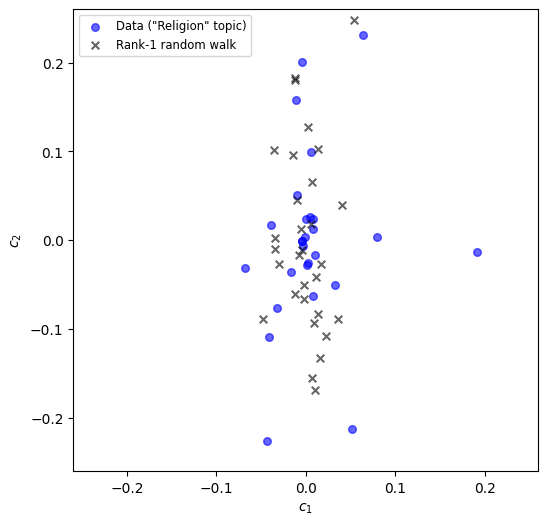

In [22]:
np.random.seed(314)

coi = 811
idx = np.where(hdbs.labels_ == coi)[0]
cmx = C[idx,:]
diffs = cmx[1:,:] - cmx[:-1,:]
diffs_2d = PCA(n_components=2).fit_transform(diffs)

steps = generate_rank1_steps(n_steps=len(idx), dim=384, sigma=0.1, noise=0.005)
steps_2d = PCA(n_components=2).fit_transform(steps)

fig, ax = plt.subplots(1,1, figsize=(6,6))

ax.scatter(diffs_2d[:,0], diffs_2d[:,1], s=30, c='b', marker='o', alpha=0.6, label='Data ("Religion" topic)')
ax.scatter(steps_2d[:,1], steps_2d[:,0], s=30, c='k', marker='x', alpha=0.6, label='Rank-1 random walk')

ax.legend(fontsize='small', loc=2)
ax.set_xlim([-0.26, 0.26])
ax.set_ylim([-0.26, 0.26])
ax.set_xlabel('$c_1$')
ax.set_ylabel('$c_2$')

plt.show()

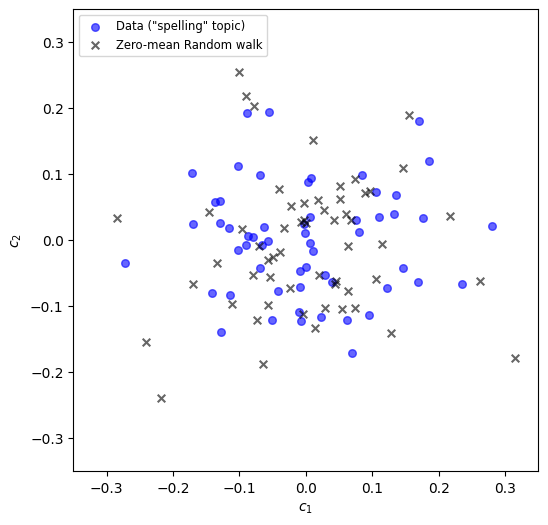

In [18]:
np.random.seed(314)

coi = 712
idx = np.where(hdbs.labels_ == coi)[0]
cmx = C[idx,:]
diffs = cmx[1:,:] - cmx[:-1,:]
diffs_2d = PCA(n_components=2).fit_transform(diffs)

d = 384
steps = np.random.multivariate_normal(np.zeros(d), 0.001 * np.eye(d), size=len(idx))
steps_2d = PCA(n_components=2).fit_transform(steps)

fig, ax = plt.subplots(1,1, figsize=(6,6))

ax.scatter(diffs_2d[:,0], diffs_2d[:,1], s=30, c='b', marker='o', alpha=0.6, label='Data ("spelling" topic)')
ax.scatter(steps_2d[:,1], steps_2d[:,0], s=30, c='k', marker='x', alpha=0.6, label='Zero-mean Random walk')

ax.legend(fontsize='small', loc=2)
ax.set_xlim([-0.35, 0.35])
ax.set_ylim([-0.35, 0.35])
ax.set_xlabel('$c_1$')
ax.set_ylabel('$c_2$')

plt.show()

In [136]:
# coi = 811

res3 = []

for coi in np.unique(hdbs.labels_):
    if coi == -1:
        continue
    
    idx = np.where(hdbs.labels_ == coi)[0]
    
    if len(idx) < 10:
        continue

    cmx = C[idx,:]
    diffs = cmx[1:,:] - cmx[:-1,:]

    # compute the distance between start and end point
    disp = np.linalg.norm(C[idx[0],:] - C[idx[-1],:])

    # compute diameter
    diam = np.max([np.linalg.norm(C[i] - C[j]) for i in idx for j in idx])

    # compute covariance concentration metrics
    r, m, s, evs = variance_concentration_ratio(diffs)
    h = spectral_entropy(evs)
    er = np.exp(h)

    res3.append([coi, len(idx), r, m, s, h, er, disp, diam])

res3 = pd.DataFrame(res3, columns=['coi', 'size', 'r', 'm', 's', 'h', 'er', 'disp', 'diam'])
res3.head()

,coi,size,r,m,s,h,er,disp,diam
0,4,19,0.679935,0.025398,0.037354,1.101025,3.007246,0.223856,0.400920
1,7,10,0.791309,0.015694,0.019833,0.720059,2.054555,0.179645,0.261595
2,8,19,0.668477,0.049399,0.073897,1.252562,3.499296,0.192649,0.434316
3,11,11,0.522121,0.030839,0.059064,1.442167,4.229854,0.351169,0.351169
4,26,16,0.399516,0.006744,0.016880,1.501527,4.488539,0.160250,0.282092


In [112]:
res3.sort_values(by='er', ascending=True).head(30)

,coi,size,r,m,s,h,er
80,491,10,0.838428,0.002704,0.003225,0.683839,1.981470
1,7,10,0.791309,0.015694,0.019833,0.720059,2.054555
173,917,10,0.768124,0.064697,0.084228,0.828302,2.289427
82,494,10,0.733888,0.002626,0.003578,0.963134,2.619893
14,81,14,0.699591,0.025934,0.037070,0.993677,2.701149
109,645,19,0.705721,0.030494,0.043210,1.028424,2.796655
148,821,11,0.715852,0.015826,0.022108,1.053593,2.867937
158,854,12,0.727527,0.034673,0.047659,1.060106,2.886678
19,109,11,0.686895,0.006875,0.010009,1.066737,2.905882
96,568,10,0.549719,0.010753,0.019560,1.088220,2.968983


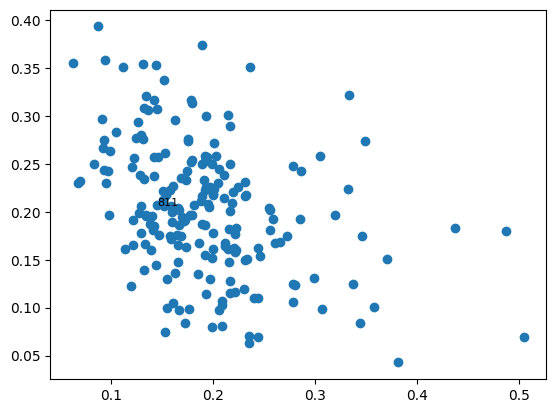

In [143]:
plt.scatter(1/res3['er'], res3['disp'])
for i, txt in enumerate(res3['coi']):
    if txt == 811:
        plt.annotate(txt, (1/res3['er'][i], res3['disp'][i]), fontsize=8)
# plt.xlabel('Variance Concentration Ratio (r)')
# plt.ylabel('Sum of Eigenvalues (s)')
plt.show()

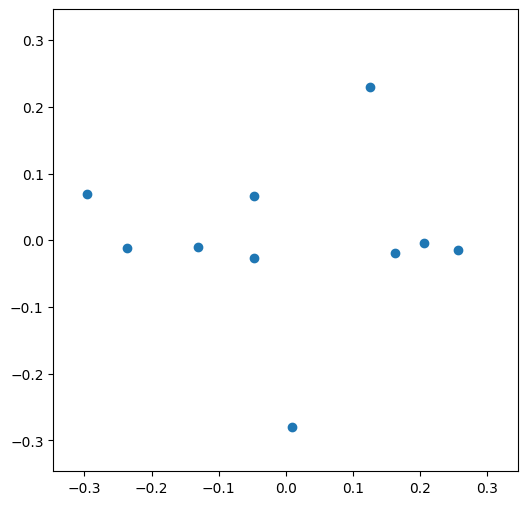

In [119]:
coi = 1003

idx = np.where(hdbs.labels_ == coi)[0]
cmx = C[idx,:]
diffs = cmx[1:,:] - cmx[:-1,:]

diffs_pca = PCA(n_components=2).fit_transform(diffs)

fig, ax = plt.subplots(1,1, figsize=(6,6))

ax.scatter(diffs_pca[:,0], diffs_pca[:,1])

m = np.amax(np.abs(diffs_pca[:,:])) + 0.05
ax.set_xlim([-m,m])
ax.set_ylim([-m,m])

plt.show()

In [130]:
low_d = 2
res4 = []

for coi in np.unique(hdbs.labels_):
    idx = np.where(hdbs.labels_ == coi)[0]

    if len(idx) < 10:
        continue

    cmx = C[idx,:]
    steps = cmx[1:,:] - cmx[:-1,:]
    steps_pca = PCA(n_components=low_d).fit_transform(steps)

    t2, fstat, p = hotelling_t2_test_single(steps_pca, mu0=np.zeros(low_d))

    res4.append([coi, len(idx), t2, fstat, p])

res4 = pd.DataFrame(res4, columns=['coi', 'size', 't2', 'f', 'p'])
res4.head()

,coi,size,t2,f,p
0,-1,2849,7.137961e-31,3.567727e-31,1.0
1,4,19,8.273762e-32,3.893535e-32,1.0
2,7,10,2.922185e-32,1.278456e-32,1.0
3,8,19,2.007685e-31,9.447931e-32,1.0
4,11,11,4.340933e-31,1.929303e-31,1.0


In [132]:
steps = np.random.multivariate_normal(np.ones(384), np.eye(384), size=30)
steps_pca = PCA(n_components=5).fit_transform(steps)

print(hotelling_t2_test_single(steps_pca))

(np.float64(5.545066762125467e-31), np.float64(9.560459934699081e-32), np.float64(1.0))


In [141]:
n, d = 50, 100  # d is large relative to n

# Generate data with a small nonzero mean in dimension d
true_mean = np.zeros(d)
true_mean[0] = 20  # only first dimension has drift
X = np.random.randn(n, d) + true_mean

Xp = PCA(n_components=2).fit_transform(X)

T2_reg, F_val, p_val = one_sample_t2_shrinkage(Xp, lam=0.8)
print(f"Regularized T^2: {T2_reg:.4f}") 
print(f"Approx. F: {F_val:.4f}") 
print(f"Approx. p-value: {p_val:.4f}")

Regularized T^2: 0.0000
Approx. F: 0.0000
Approx. p-value: 1.0000


In [145]:
from scipy.stats import wasserstein_distance_nd

In [146]:
steps = np.random.multivariate_normal(np.ones(384), np.eye(384), size=30)
steps0 = np.random.multivariate_normal(np.zeros(384), np.eye(384), size=30)

wasserstein_distance_nd(steps, steps0)

32.92955542447149

# lrt

## initial

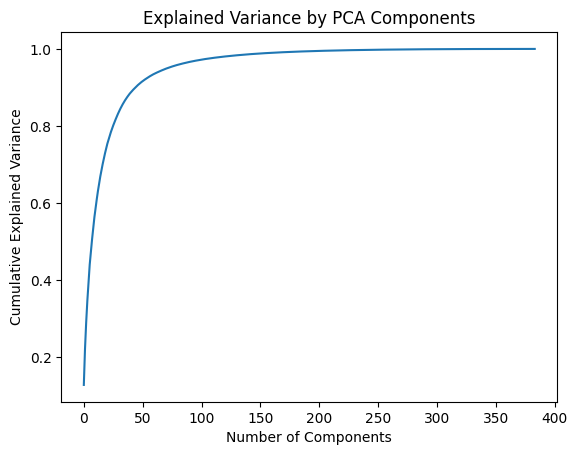

In [23]:
# explained variance for PCA

pca = PCA()
pca.fit(C)
explained_variance = pca.explained_variance_ratio_
plt.plot(np.cumsum(explained_variance))
plt.xlabel('Number of Components')
plt.ylabel('Cumulative Explained Variance')
plt.title('Explained Variance by PCA Components')
plt.show()

In [63]:
np.cumsum(pca.explained_variance_ratio_)[10:30]

array([0.58650813, 0.60963771, 0.63107454, 0.65043109, 0.66878885,
       0.68513505, 0.70063302, 0.71538296, 0.72888027, 0.74192492,
       0.75389554, 0.7642544 , 0.77441022, 0.78407077, 0.79315988,
       0.8013718 , 0.80931967, 0.81688125, 0.82434056, 0.83143201])

In [74]:
# compute avg step and compute log-likelihood ratio for all cois

labels = []
avg_steps = []
log_ll = []

Cp = PCA(n_components=10).fit_transform(C)

for coi in np.unique(hdbs.labels_):
    idx = np.where(hdbs.labels_ == coi)[0]
    T = len(idx)

    if T < 5:
        continue

    labels.append(coi)

    # cmx = C[idx,:]
    cmx = Cp[idx,:]
    steps = cmx[1:,:] - cmx[:-1,:]
    avg_step = np.mean(steps, axis=0)
    avg_steps.append(avg_step)

    cov = np.cov(steps, rowvar=False, ddof=1)
    lam = 0.5 * (T - 1) * (avg_step.T @ np.linalg.pinv(cov) @ avg_step)
    log_ll.append(lam)

avg_steps = np.vstack(avg_steps)
labels = np.array(labels)
log_ll = np.array(log_ll)

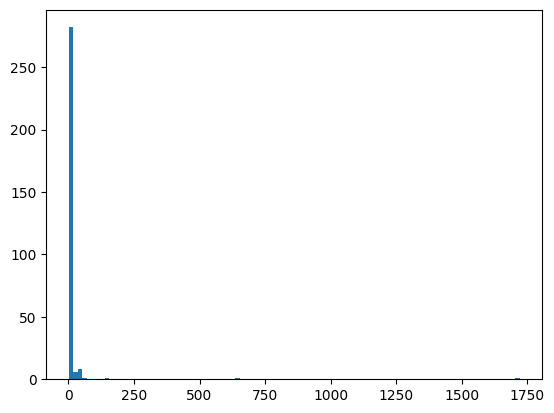

In [76]:
plt.hist(log_ll[log_ll > 1], 100)
plt.show()

In [32]:
labels[log_ll > 15]

array([  87,   93,  258,  326,  358,  428,  449,  540,  919,  987, 1001])

In [44]:
int(3.1)

3

/local/scr/stmorse/TMPDIR/ipykernel_226071/3921225813.py:20: UserWarning: *c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
  ax.scatter(Cu2d[idx,0], Cu2d[idx,1], c=col, s=40, alpha=a)


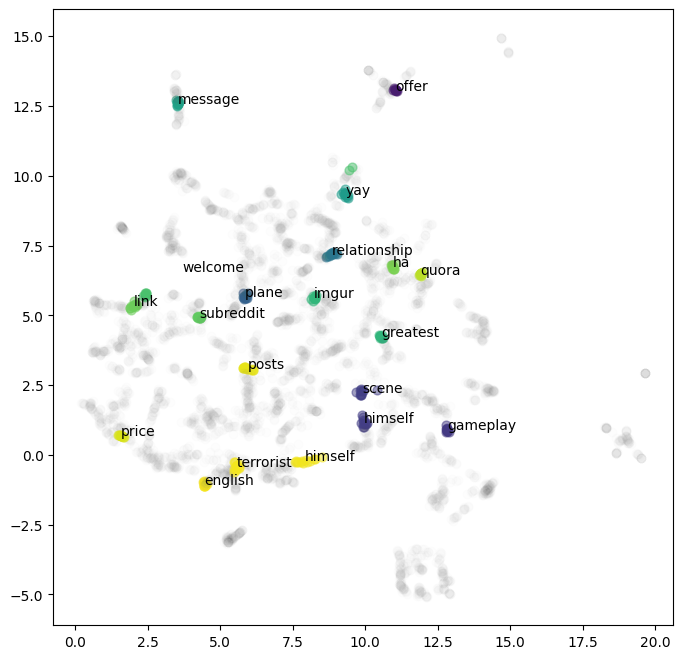

In [84]:
fig, ax = plt.subplots(1,1, figsize=(8,8))

n_clusters = np.amax(hdbs.labels_)
colors = plt.cm.viridis(np.linspace(0, 1, n_clusters))

for i, coi in enumerate(labels):
    if coi in [-1, 0, 1, 1005]:
        continue

    if group_keywords[coi] == '00':
        continue

    idx = np.where(hdbs.labels_ == coi)[0]
    ll = int(log_ll[i])
    col = colors[coi]
    a = 0.5
    if ll < 18:
        col = 'gray'
        a = 0.01
    ax.scatter(Cu2d[idx,0], Cu2d[idx,1], c=col, s=40, alpha=a)
    
    if ll >= 18:
        centroid = np.mean(Cu2d[idx,:2], axis=0)
        ax.text(centroid[0], centroid[1], group_keywords[coi])

plt.show()

In [82]:
stats.chi2.sf(19, df=10)

np.float64(0.04026268234060996)

In [83]:
labels[log_ll > 18]

array([ 79, 169, 184, 187, 308, 394, 547, 575, 655, 659, 715, 758, 777,
       803, 901, 944, 965, 983, 988, 991])

In [73]:
log_ll[log_ll > 32]

array([ 49.0823843 ,  35.86204339,  59.90044239, 198.56711358,
        65.06353778,  69.18364772])

## with perm testing

In [6]:
C.shape

(10200, 384)

In [7]:
labels = []
log_ll = []
p_value_empirical = []

res5 = []

Cp = PCA(n_components=45).fit_transform(C)

for coi in np.unique(hdbs.labels_):
    if coi == -1:
        continue

    idx = np.where(hdbs.labels_ == coi)[0]
    T = len(idx)

    if T < 5:
        continue

    labels.append(coi)

    # diam and displ
    diam = np.amax([np.linalg.norm(C[i,:] - C[j,:]) for i in idx for j in idx])
    disp = np.linalg.norm(C[idx[-1],:] - C[idx[0],:])

    # cmx = C[idx,:]
    cmx = Cp[idx,:]
    steps = cmx[1:,:] - cmx[:-1,:]
    avg_step = np.mean(steps, axis=0)
    cov = np.cov(steps, rowvar=False, ddof=1)
    pinv = np.linalg.pinv(cov)

    obs_lam = 0.5 * (T - 1) * (avg_step.T @ pinv @ avg_step)
    log_ll.append(obs_lam)

    shuffled_lam = []
    n_permutations = 10000
    for _ in range(n_permutations):
        cmx_c = cmx[:,:]
        np.random.shuffle(cmx_c)
        steps_shuffled = cmx_c[1:, :] - cmx_c[:-1, :]
        avg_step_shuffled = np.mean(steps_shuffled, axis=0)
        lam_shuffled = 0.5 * (T - 1) * (avg_step_shuffled.T @ pinv @ avg_step_shuffled)
        shuffled_lam.append(lam_shuffled)

    pve = np.mean(np.array(shuffled_lam) > obs_lam)
    p_value_empirical.append(pve)

    res5.append([coi, T, diam, disp, obs_lam, pve])

labels = np.array(labels)
log_ll = np.array(log_ll)
p_value_empirical = np.array(p_value_empirical)

res5 = pd.DataFrame(res5, columns=['coi', 'size', 'diam', 'disp', 'lam', 'pve'])

In [8]:
res6 = res5.copy()
res6['name'] = [group_keywords[coi] if coi != 1005 else 'politics' for coi in res6['coi']]

In [10]:
res6.query('size >= 5').sort_values(by='disp', ascending=True).head(20)

,coi,size,diam,disp,lam,pve,name
11,14,9,0.030927,0.010984,2.031366,0.0292,sexy
14,21,7,0.069562,0.016081,0.305122,0.9179,00
283,510,5,0.050340,0.031661,0.141558,0.9000,her
138,244,5,0.038975,0.037678,0.052805,0.8967,music
4,6,9,0.096811,0.038287,1.496818,0.2236,que
272,494,10,0.112495,0.042712,0.660071,0.4565,her
87,146,6,0.101211,0.043743,0.112669,0.9422,team
25,40,5,0.045431,0.044366,0.388577,0.2905,de
20,32,6,0.052555,0.044593,3.557206,0.0660,eu
24,39,9,0.055055,0.045299,0.479294,0.6918,de


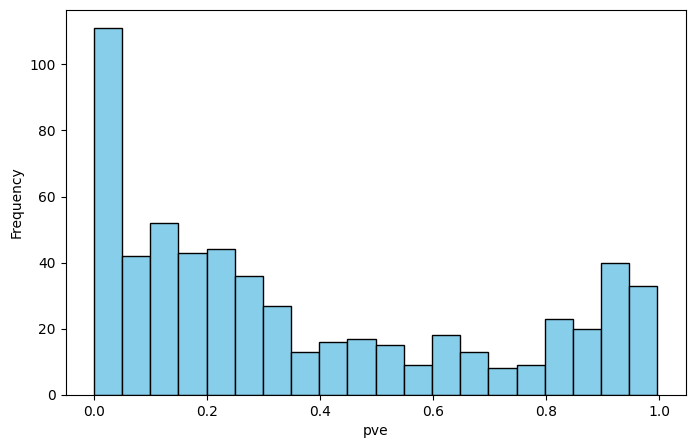

In [9]:
plt.figure(figsize=(8, 5))
plt.hist(res6['pve'], bins=20, color='skyblue', edgecolor='black')
plt.xlabel('pve')
plt.ylabel('Frequency')
plt.show()

Text(0, 0.5, 'displacement')

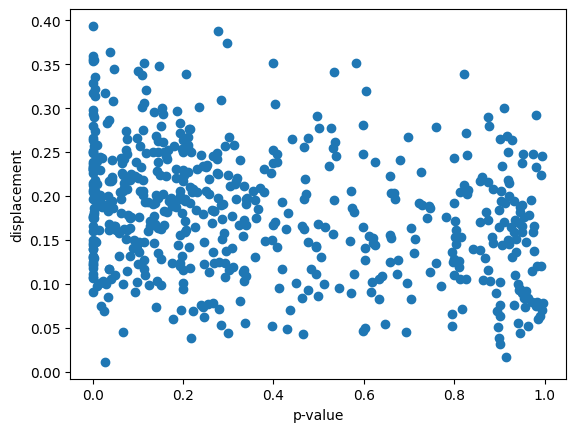

In [75]:
plt.scatter(res5['pve'], res5['disp'])
plt.xlabel('p-value')
plt.ylabel('displacement')

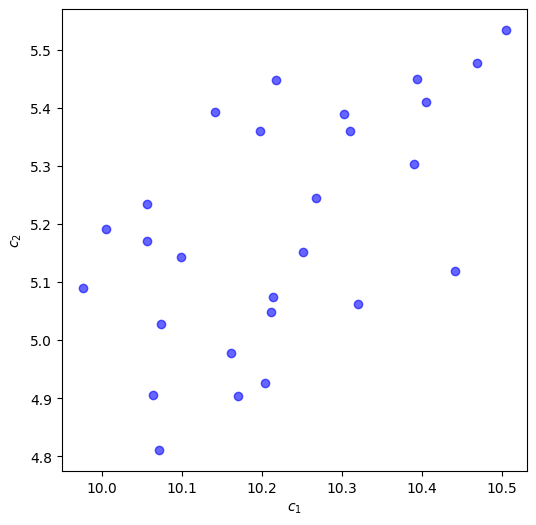

In [80]:
fig, ax = plt.subplots(1,1, figsize=(6,6))

cois1 = [774]
for coi in cois1:
    idx = np.where(hdbs.labels_ == coi)[0]
    ax.scatter(Cu2d[idx,0], Cu2d[idx,1], c='b', alpha=0.6)

ax.set_xlabel('$c_1$')
ax.set_ylabel('$c_2$')

plt.show()

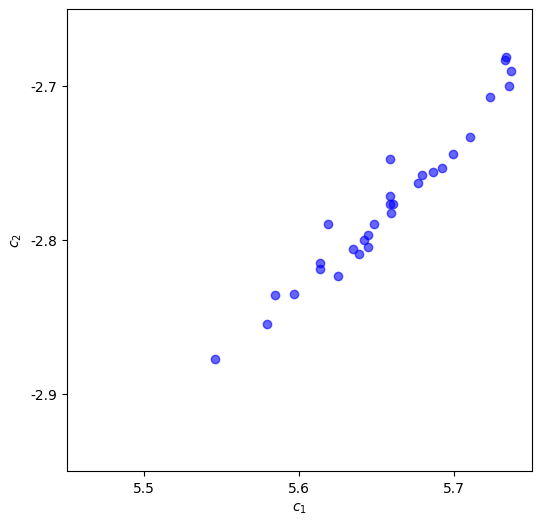

In [78]:
fig, ax = plt.subplots(1,1, figsize=(6,6))

cois2 = [811]
for coi in cois2:
    idx = np.where(hdbs.labels_ == coi)[0]
    ax.scatter(Cu2d[idx,0], Cu2d[idx,1], c='b', alpha=0.6)

ax.set_xticks([5.5, 5.6, 5.7])
ax.set_xticklabels([5.5, 5.6, 5.7])
ax.set_yticks([-2.9, -2.8, -2.7])
ax.set_yticklabels([-2.9, -2.8, -2.7])

ax.set_xlim([5.45, 5.75])
ax.set_ylim([-2.95, -2.65])

ax.set_xlabel('$c_1$')
ax.set_ylabel('$c_2$')

plt.show()

/local/scr/stmorse/TMPDIR/ipykernel_114963/148393760.py:20: UserWarning: *c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
  ax.scatter(Cu2d[idx,0], Cu2d[idx,1], s=30, c=colors[coi], alpha=0.5)


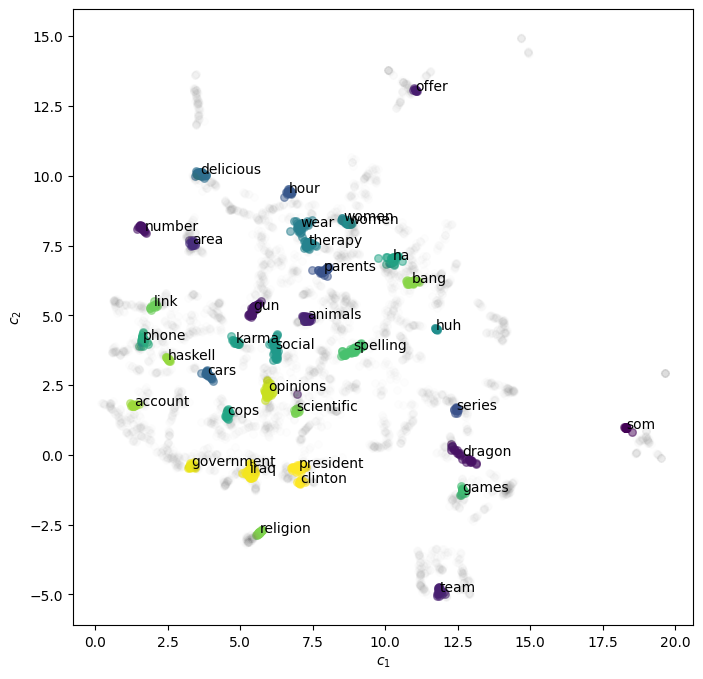

In [62]:
fig, ax = plt.subplots(1,1, figsize=(8,8))

colors = plt.cm.viridis(np.linspace(0, 1, 1005))

select_cois = res5[(res5['size'] >= 10) & (res5['lam'] >= 5)]['coi'].tolist()

for coi in np.unique(hdbs.labels_):
    if coi in [-1, 0, 1, 1005]:
        continue

    if group_keywords[coi] == '00':
        continue

    idx = np.where(hdbs.labels_ == coi)[0]

    if len(idx) < 5:
        continue

    if coi in select_cois:
        ax.scatter(Cu2d[idx,0], Cu2d[idx,1], s=30, c=colors[coi], alpha=0.5)
        centroid = np.mean(Cu2d[idx,:2], axis=0)
        ax.text(centroid[0], centroid[1], group_keywords[coi])
    else:
        ax.scatter(Cu2d[idx,0], Cu2d[idx,1], s=30, c='gray', alpha=0.01)

ax.set_xlabel('$c_1$')
ax.set_ylabel('$c_2$')

plt.show()

In [81]:
res5.query('coi == 811')['pve']

466    0.0
Name: pve, dtype: float64

# single time window

In [5]:
import umap

/sciclone/geograd/stmorse/dtm/venv/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## single year

In [12]:
year = 2008
month = 11

# load embeddings
with open(f'/sciclone/geograd/stmorse/reddit/embeddings/embeddings_{year}-{month:02}.npz', 'rb') as f:
    embeddings = np.load(f)['embeddings']
    print(embeddings.shape)

# load labels
with open(os.path.join(base_path, f'labels/labels_{year}-{month:02}.npz'), 'rb') as f:
    labels = np.load(f)['labels']
    print(labels.shape)

# load cc
with open(os.path.join(base_path, f'models/model_cc_{year}-{month:02}.npz'), 'rb') as f:
    ccs = np.load(f)['cc']
    print(ccs.shape)

# load tfidf
with open(os.path.join(base_path, f'tfidf/tfidf_{year}-{month:02}.pkl'), 'rb') as f:
    tfidf = pickle.load(f)['tfidf']
    print(len(tfidf))

(526493, 384)
(526493,)
(50, 384)
50


In [13]:
# sample closest 100 from each label
s = 200
embed_sample = []
label_sample = []

for label in np.unique(labels):
    idx = np.where(labels == label)[0]
    dists = np.linalg.norm(embeddings[idx,:] - ccs[label], axis=1)
    idx = idx[np.argsort(dists)[:s]]
    # idx = np.random.choice(idx, size=100, replace=False)
    z = embeddings[idx,:]
    embed_sample.append(z)
    label_sample.append([label] * s)

embed_sample = np.vstack(embed_sample)
label_sample = np.concatenate(label_sample)
print(embed_sample.shape)

(10000, 384)


In [14]:
embed2d = umap.UMAP(
    n_components=2,
    min_dist=0.3,
).fit_transform(embed_sample)

/sciclone/geograd/stmorse/dtm/venv/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


/local/scr/stmorse/TMPDIR/ipykernel_697121/3627835158.py:7: UserWarning: *c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
  ax.scatter(embed2d[idx,0], embed2d[idx,1], s=30, c=colors[label], alpha=0.05)


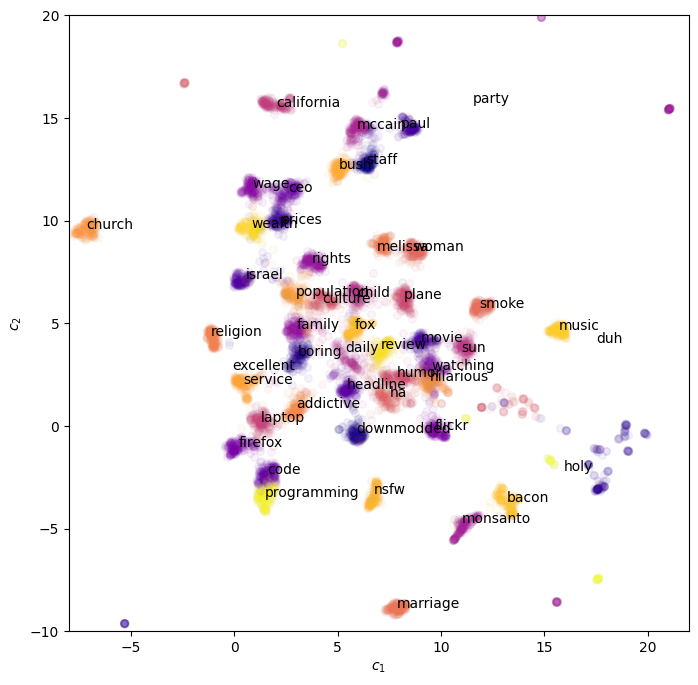

In [17]:
fig, ax = plt.subplots(1,1, figsize=(8,8))

colors = plt.cm.plasma(np.linspace(0, 1, 50))

for label in np.unique(labels):
    idx = np.where(label_sample == label)[0]
    ax.scatter(embed2d[idx,0], embed2d[idx,1], s=30, c=colors[label], alpha=0.05)
    
    centroid = np.mean(embed2d[idx,:], axis=0)
    ax.annotate(tfidf[label]['keywords'][0], (centroid[0], centroid[1]))

ax.set_xlim([-8,22])
ax.set_ylim([-10,20])
ax.set_xlabel('$c_1$')
ax.set_ylabel('$c_2$')

plt.show()

In [20]:
embed_samples = []
label_samples = []
tf_idfs = []

for year, month in zip([2007, 2008], [6, 6]):
    # load embeddings
    with open(f'/sciclone/geograd/stmorse/reddit/embeddings/embeddings_{year}-{month:02}.npz', 'rb') as f:
        embeddings = np.load(f)['embeddings']
        print(embeddings.shape)

    # load labels
    with open(os.path.join(base_path, f'labels/labels_{year}-{month:02}.npz'), 'rb') as f:
        labels = np.load(f)['labels']
        print(labels.shape)

    # load cc
    with open(os.path.join(base_path, f'models/model_cc_{year}-{month:02}.npz'), 'rb') as f:
        ccs = np.load(f)['cc']
        print(ccs.shape)

    # load tfidf
    with open(os.path.join(base_path, f'tfidf/tfidf_{year}-{month:02}.pkl'), 'rb') as f:
        tfidf = pickle.load(f)['tfidf']
        print(len(tfidf))

    # sample closest s from each label
    s = 200
    embed_sample = []
    label_sample = []

    for label in np.unique(labels):
        idx = np.where(labels == label)[0]
        dists = np.linalg.norm(embeddings[idx,:] - ccs[label], axis=1)
        idx = idx[np.argsort(dists)[:s]]
        # idx = np.random.choice(idx, size=100, replace=False)
        z = embeddings[idx,:]
        embed_sample.append(z)
        label_sample.append([label] * s)

    embed_sample = np.vstack(embed_sample)
    embed_samples.append(embed_sample)
    label_sample = np.concatenate(label_sample)
    label_samples.append(label_sample)
    tf_idfs.append(tfidf)
    print(embed_sample.shape)

    del embeddings
    del labels
    del ccs

embed_samples = np.vstack(embed_samples)
label_samples = np.vstack(label_samples)

(118493, 384)
(118493,)
(50, 384)
50
(10000, 384)
(387632, 384)
(387632,)
(50, 384)
50
(10000, 384)


In [9]:
embed_samples.shape

(20000, 384)

In [12]:
label_samples.shape

(2, 10000)

In [21]:
embed2d = umap.UMAP(
    n_components=2,
    min_dist=0.1,
).fit_transform(embed_samples)

/sciclone/geograd/stmorse/dtm/venv/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


/local/scr/stmorse/TMPDIR/ipykernel_604832/826900127.py:9: UserWarning: *c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
  ax.scatter(embed2d[idx,0], embed2d[idx,1], s=30, c=colors[label], alpha=0.05)


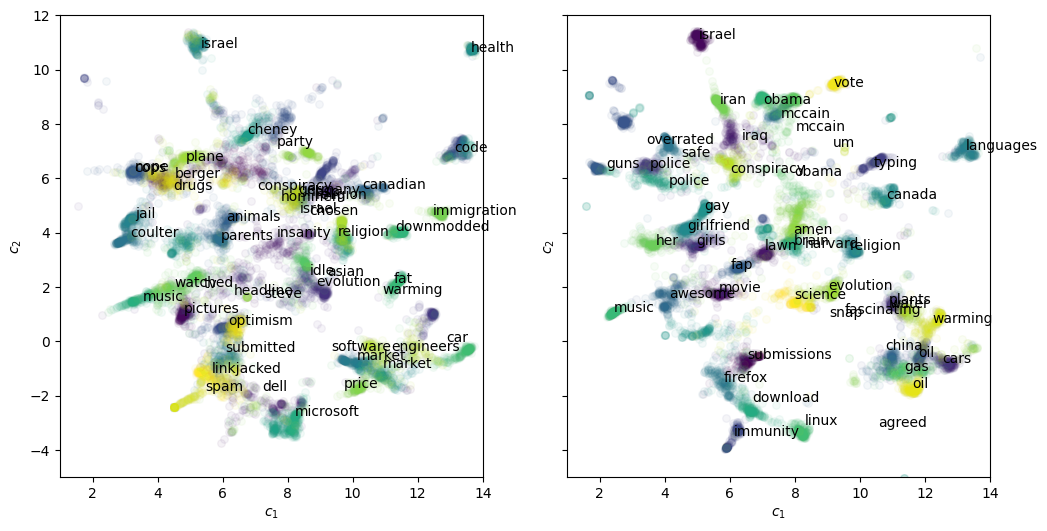

In [26]:
fig, axs = plt.subplots(1,2, figsize=(12,6), sharey=True)

colors = plt.cm.viridis(np.linspace(0, 1, 50))

for i, ax in enumerate(axs):
    for label in np.arange(50):
        offset = 0 if i==0 else 10000
        idx = np.where(label_samples[i,:] == label)[0] + offset
        ax.scatter(embed2d[idx,0], embed2d[idx,1], s=30, c=colors[label], alpha=0.05)
        
        centroid = np.mean(embed2d[idx,:], axis=0)
        ax.annotate(tf_idfs[i][label]['keywords'][0], (centroid[0], centroid[1]))

    ax.set_xlim([1,14])
    ax.set_ylim([-5,12])
    ax.set_xlabel('$c_1$')
    ax.set_ylabel('$c_2$')

fig.savefig('../output/two_year_0706_0806.pdf')
plt.show()

/local/scr/stmorse/TMPDIR/ipykernel_604832/3724704619.py:11: UserWarning: *c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
  ax.scatter(embed2d[idx,0], embed2d[idx,1], s=30, c=colors[label], alpha=0.05)


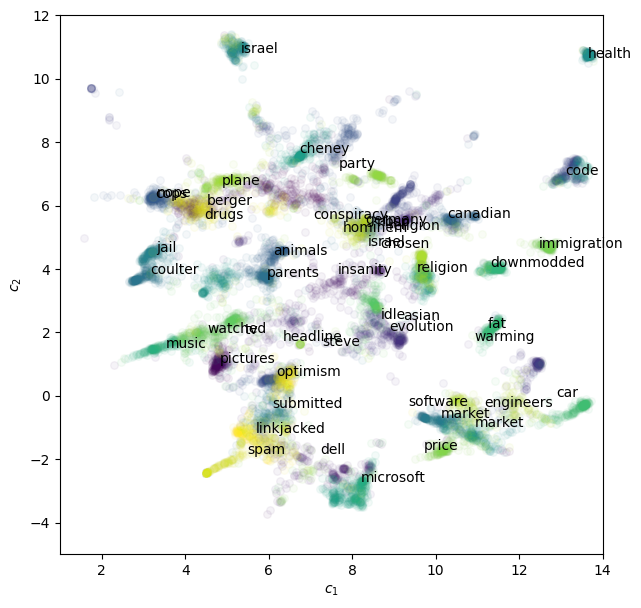

In [31]:
fig, ax = plt.subplots(1,1, figsize=(7,7), sharey=True)

i = 0
fn = ['0706', '0806']

colors = plt.cm.viridis(np.linspace(0, 1, 50))

for label in np.arange(50):
    offset = 0 if i==0 else 10000
    idx = np.where(label_samples[i,:] == label)[0] + offset
    ax.scatter(embed2d[idx,0], embed2d[idx,1], s=30, c=colors[label], alpha=0.05)
    
    centroid = np.mean(embed2d[idx,:], axis=0)
    ax.annotate(tf_idfs[i][label]['keywords'][0], (centroid[0], centroid[1]))

ax.set_xlim([1,14])
ax.set_ylim([-5,12])
ax.set_xlabel('$c_1$')
ax.set_ylabel('$c_2$')

fig.savefig(f'../output/one_year_{fn[i]}.png')
plt.show()